In [1]:
import mne
from scipy.io import loadmat
import numpy as np

In [2]:
def file_to_data(fileName):
    chnames = ['Fp1','Fp2','Fc5','Fz','Fc6','T7','Cz','T8','P7','P3','Pz','P4','P8','O1','Oz','O2','stim']
    chtypes = ['eeg'] * 16 + ['stim']
    info = mne.create_info(ch_names=chnames, sfreq=512,ch_types=chtypes, montage='standard_1020',verbose=False)
    data = loadmat(fileName)["SIGNAL"]
    #On modifie pour avoir un dataset avec 1 : yeux ouvert et -1 yeux fermée
    new_data=[]
    yeux_ouvert=False
    for k in range(len(data)):
        if(yeux_ouvert==False):
            tmp=np.append(data[k][1:17],-1)
        else:
            tmp=np.append(data[k][1:17],1)
        new_data.append(tmp)
        if(data[k][17]==1):
            yeux_ouvert=True
        if(data[k][18]==1):
            yeux_ouvert=False
    labels= [d[16] for d in new_data]
    donnees = [d[:16] for d in new_data]
    return donnees,labels

In [3]:
donnees,labels = file_to_data("data/subject_01.mat")

In [4]:
import pyriemann
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.linear_model import SGDClassifier

In [11]:
def cross_val_riemann(donnees,labels,nb_trail):
    nb_paquet=int(len(donnees)/nb_trail)
    donnees = donnees[:nb_trail*nb_paquet]
    X=np.array(np.split(np.array(donnees), nb_paquet))#Ntrial*Nchannels*Nsample
    X=np.swapaxes(X,1,2)
    #estimer la matrice de covariance
    cov = pyriemann.estimation.Covariances().fit_transform(X)

    cov = cov.reshape((len(cov),len(cov[0])*len(cov[0][0])))


    #validation croisée
    clf = SGDClassifier(loss="perceptron", eta0=1e-4, learning_rate="constant", penalty=None,tol=1e-1,max_iter=10000,shuffle=True)
    #On modifie les y pour qu'il y est qu'un chiffre tout les 52 enregistrement, on prendra dans un premier temps juste
    #le premier label sur les 52 pour estimer les 52 suivant
    labels = labels[:nb_trail*nb_paquet]
    yTemp = np.array(np.split(np.array(labels), nb_paquet))
    Y=[]
    for u in yTemp:
        if(np.mean(u)>0):
            Y.append(1)
        else:
            Y.append(-1)
    Y=np.array(Y)
    y_pred = cross_val_predict(clf,cov,Y,cv=5)
    rapport = classification_report(Y, y_pred,output_dict=True)
    return rapport['micro avg']["f1-score"]

In [12]:
#512 Hz
#On prend 52 trial par échantillon pour avoir un temps de reaction d'environ 0,1015625s
#On supprime les derniers echantillons pour avoir un multiple de 52 et donc des matrices completes
tab_trail=[]
result_f1Score=[]
for mult in range(2,50):
    nb_trail=mult*10
    print(nb_trail)
    tab_trail.append(nb_trail)
    f1Score = cross_val_riemann(donnees,labels,nb_trail)
    result_f1Score.append(f1Score)
    print("F1 Score riemann : "+str(f1Score))

20
F1 Score riemann : 0.6889816360601002
30
F1 Score riemann : 0.6536438767843726
40
F1 Score riemann : 0.6901502504173622
50
F1 Score riemann : 0.6919866444073456
60
F1 Score riemann : 0.6092184368737475
70
F1 Score riemann : 0.6803039158386909
80
F1 Score riemann : 0.6526386105544422
90
F1 Score riemann : 0.6566491359879789
100
F1 Score riemann : 0.6861435726210351
110
F1 Score riemann : 0.6492194674012856
120
F1 Score riemann : 0.5881763527054108
130
F1 Score riemann : 0.5667752442996743
140
F1 Score riemann : 0.5614035087719298
150
F1 Score riemann : 0.606516290726817
160
F1 Score riemann : 0.5962566844919787
170
F1 Score riemann : 0.59375
180
F1 Score riemann : 0.6390977443609023
190
F1 Score riemann : 0.5761904761904761
200
F1 Score riemann : 0.6043405676126878
210
F1 Score riemann : 0.5456140350877193
220
F1 Score riemann : 0.5625
230
F1 Score riemann : 0.5038461538461538
240
F1 Score riemann : 0.45090180360721444
250
F1 Score riemann : 0.4697286012526096
260
F1 Score riemann : 

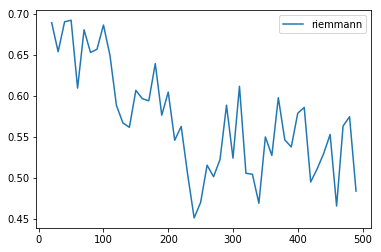

In [13]:
import matplotlib.pyplot as plt
plt.plot(tab_trail,result_f1Score,label="riemmann")
plt.legend()
plt.show()